# Homework 4

Alec Bell, David Lee

In [2]:
# Import functions needed for all tasks

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# Load images.

frameLeftGray = plt.imread('H4_post_for_students/frameLeftgray.png')
# frameLeftGray = cv2.cvtColor(frameLeftGray, cv2.COLOR_BGR2GRAY)


frameRightGray = plt.imread('H4_post_for_students/frameRightgray.png')
# frameRightGray = cv2.cvtColor(frameRightGray, cv2.COLOR_BGR2GRAY)

matlabResult = plt.imread('H4_post_for_students/disparityMap_Matlab.png')
# matlabResult = cv2.cvtColor(matlabResult, cv2.COLOR_BGR2GRAY)

In [4]:
# Declare function for easily showing images.

def show_images(img1, img2, img3):
    plt.figure(figsize=(20, 20))
    
    plt.subplot(2, 2, 1)
    plt.title("window_size=1")
    plt.imshow(img1, cmap='Greys')

    plt.subplot(2,2,2)
    plt.title("window_size=3")
    plt.imshow(img2, cmap='Greys')

    plt.subplot(2,2,3)
    plt.title("window_size=5")
    plt.imshow(img3, cmap='Greys')

    plt.subplot(2,2,4)
    plt.title("matlab")
    plt.imshow(matlabResult, cmap='Greys')

### Task 1: Disparity

Below are three functions I have created to implement this algorithm.

In [5]:
def ssd(window_1, window_2):
    diff = window_1 - window_2
    return np.sum(diff**2)

In [6]:
def find_window(img, row, col, window_size):
    num_rows = img.shape[0]
    num_columns = img.shape[1]
    radius = int(window_size/2)
    
    # Find indices bounding the window, handling edge cases.
    top_idx = row-radius if row-radius >= 0 else 0
    bottom_idx = row+radius if row+radius <= num_rows else num_rows
    left_idx = col-radius if col-radius >= 0 else 0
    right_idx = col+radius if col+radius <= num_columns else num_columns
    
    # Return window based on bounding indices.
    return img[top_idx:bottom_idx+1,left_idx:right_idx+1]

In [9]:
def disparity(left, right, window_size=3, max_disparity=64):
    # Initialize the resulting disparity image with zeros.
    result = np.zeros(left.shape, dtype=left.dtype)
    
    for i in range(left.shape[0]):
        for j_1 in range(left.shape[1]):
            # Get the left window.
            window_left = find_window(left, i, j_1, window_size)
            
            # Keep track of minimum ssd and the true distance between pixels.
            min_ssd = 10000000000000
            dist = 0
            
            # Find minimum ssd across the row in the right image.
            # We only care to look across the row because the images are stereoscopic, meaning the row is the epipolar line.
            for j_2 in range(right.shape[1]):
                window_right = find_window(right, i, j_2, window_size)
                
                # Ignore cases where shapes of windows are unequal
                if window_left.shape != window_right.shape:
                    continue
                
                current_ssd = ssd(window_left, window_right)
                if current_ssd < min_ssd:
                    min_ssd = current_ssd
                    dist = abs(j_1-j_2)
            
            # Set the disparity value.
            disparity = dist if dist <= max_disparity else max_disparity
            pixel = int(disparity*255 / max_disparity)
            result[i][j_1] = 255-pixel
    
    return result

Below are the examples of this algorithm in action.

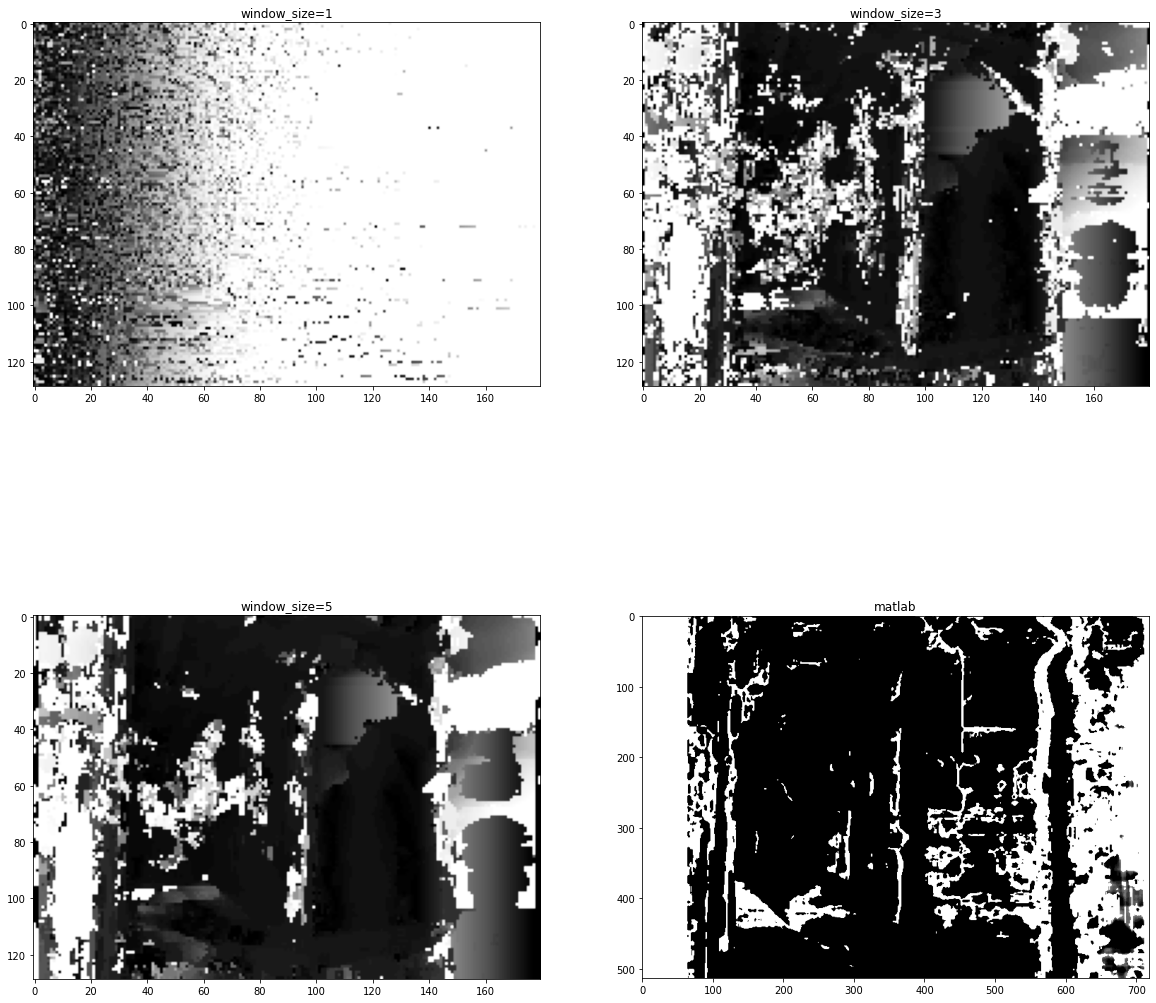

In [10]:
show_images( \
    disparity(frameLeftGray, frameRightGray, window_size=1), \
    disparity(frameLeftGray, frameRightGray, window_size=3), \
    disparity(frameLeftGray, frameRightGray, window_size=5)
)

### Task 2: Uniqueness Constraint

Below is a new implementation of the `disparity` function above that includes a uniqueness constraint so no two points are associated with each another more than once.

In [11]:
def disparity_2(left, right, window_size=3, max_disparity=64):
    # Initialize the resulting disparity image with zeros.
    result = np.zeros(left.shape, dtype=left.dtype)
    
    for i in range(left.shape[0]):
        # Keep track of pixels in the right image that have already been associated with a pixel in the left image.
        indices = set()
        
        for j_1 in range(left.shape[1]):
            # Get the left window.
            window_left = find_window(left, i, j_1, window_size)
            
            # Keep track of minimum ssd and the true distance between pixels.
            min_ssd = 10000000000000
            dist = 0
            idx = 0
            
            # Find minimum ssd across the row in the right image.
            # We only care to look across the row because the images are stereoscopic, meaning the row is the epipolar line.
            for j_2 in range(right.shape[1]):
                # Apply uniqueness constraint.
                if j_2 in indices:
                    continue
                
                window_right = find_window(right, i, j_2, window_size)
                
                # Ignore cases where shapes of windows are unequal
                if window_left.shape != window_right.shape:
                    continue
                
                current_ssd = ssd(window_left, window_right)
                if current_ssd < min_ssd:
                    min_ssd = current_ssd
                    dist = abs(j_1-j_2)
                    idx = j_2
            
            # Set the disparity value.
            disparity = dist if dist <= max_disparity else max_disparity
            pixel = int(disparity*255 / max_disparity)
            result[i][j_1] = 255-pixel
            
            # Add index to set of indices.
            indices.add(idx)
    
    return result

Below are examples of this algorithm in action.

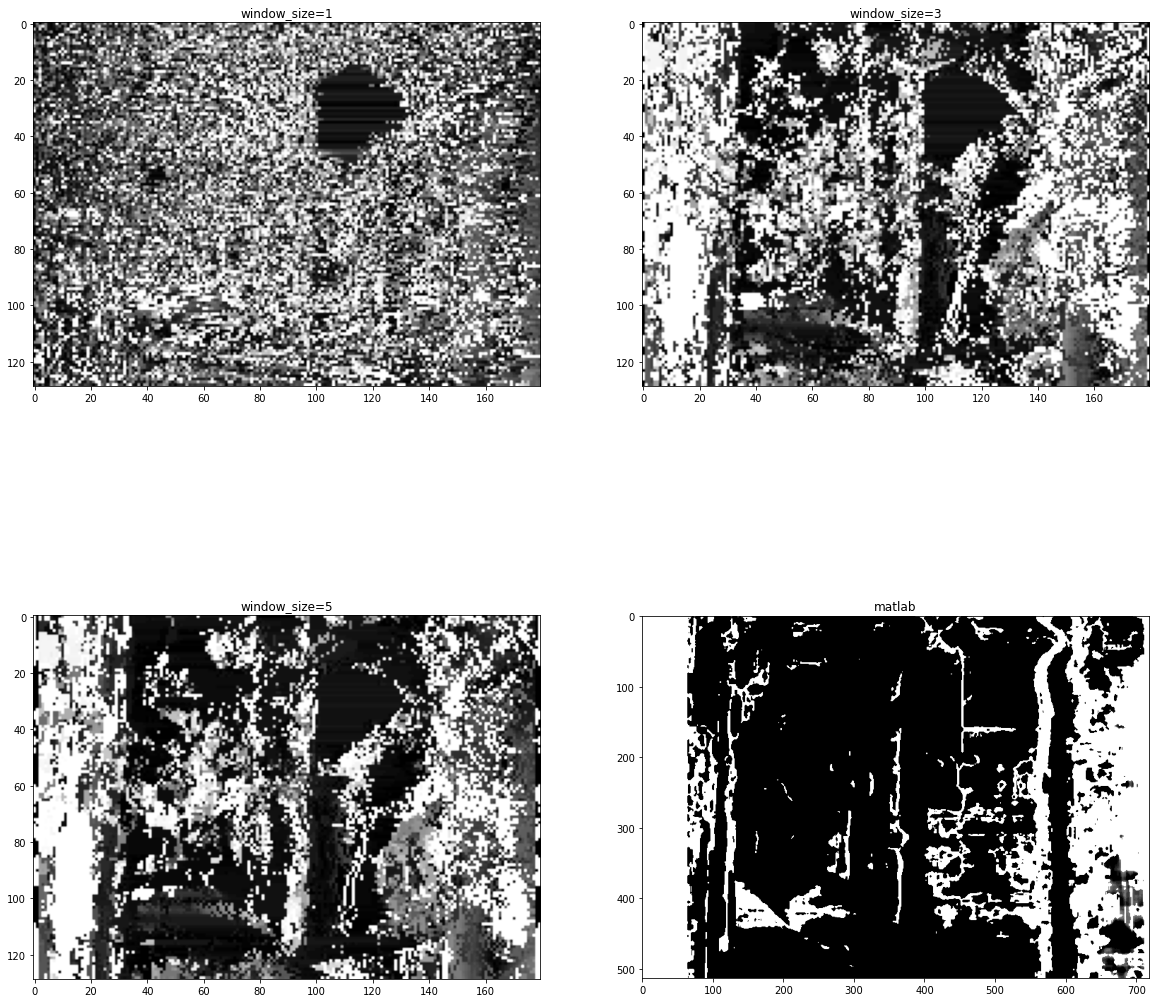

In [12]:
show_images( \
    disparity_2(frameLeftGray, frameRightGray, window_size=1), \
    disparity_2(frameLeftGray, frameRightGray, window_size=3), \
    disparity_2(frameLeftGray, frameRightGray, window_size=5)
)

### Task 3: Smoothness Constraint

Below is a new implementation of the `disparity_2` function above in Task 2 that includes a smoothness constraint. Rather than simply finding whatever distance minimizes the SSD, it finds `X` minimum SSDs and their respective distances. Of those, whichever causes the smallest spike in distance from the last evaluated pixel, that is the one that is applied.

In [13]:
def disparity_3(left, right, window_size=3, max_disparity=64, threshold=0.0):
    from queue import PriorityQueue
    
    # Initialize the resulting disparity image with zeros.
    result = np.zeros(left.shape, dtype=left.dtype)
    
    for i in range(left.shape[0]):
        # Keep track of pixels in the right image that have already been associated with a pixel in the left image.
        indices = set()
        
        # Keep track of last index used
        last_idx = 0
        
        for j_1 in range(left.shape[1]):
            # Get the left window.
            window_left = find_window(left, i, j_1, window_size)
            
            # Find minimum ssd's across the row in the right image.
            pq = PriorityQueue()
            for j_2 in range(right.shape[1]):
                # Apply uniqueness constraint.
                if j_2 in indices:
                    continue
                
                window_right = find_window(right, i, j_2, window_size)
                
                # Ignore cases where shapes of windows are unequal
                if window_left.shape != window_right.shape:
                    continue
                
                current_ssd = ssd(window_left, window_right)
                dist = abs(j_1-j_2)
                pq.put((current_ssd, dist, j_2))
                
            # Take dist with lowest spike from first <values_to_evaluate> elements
            a = 0
            min_diff = 100000000000
            current_dist = 0
            next_idx = 0
            
            current_ssd, dist, idx = pq.get()
            diff = abs(idx-last_idx)
            first_ssd = current_ssd
            while current_ssd-first_ssd < threshold and not pq.empty():
                if diff < min_diff:
                    min_diff = diff
                    current_dist = dist
                    next_idx = idx
                current_ssd, dist, idx = pq.get()
                diff = abs(idx-last_idx)
            
            # Set the disparity value.
            disparity = current_dist if current_dist <= max_disparity else max_disparity
            pixel = int(disparity*255 / max_disparity)
            result[i][j_1] = 255-pixel
            
            # Add index to set of indices.
            indices.add(idx)
            
            # Update last index
            last_idx = next_idx
    
    return result

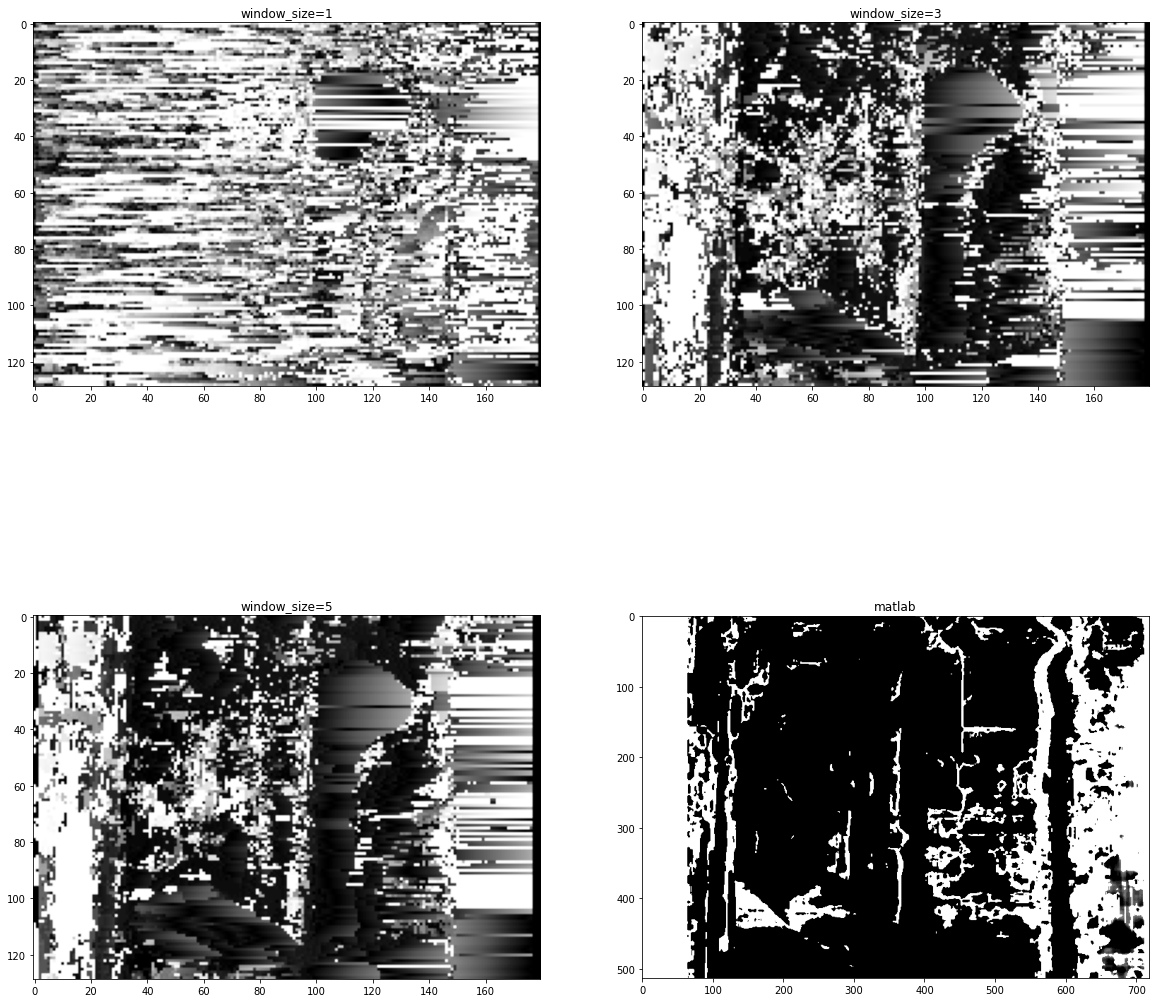

In [14]:
show_images( \
    disparity_3(frameLeftGray, frameRightGray, window_size=1, threshold=0.01), \
    disparity_3(frameLeftGray, frameRightGray, window_size=3, threshold=0.01), \
    disparity_3(frameLeftGray, frameRightGray, window_size=5, threshold=0.01)
)

### Task 4: Outliers Map

The function below creates an outliers map from left and right image disparity maps.

In [15]:
def outliers(left_disparity, right_disparity, threshold=1):
    diffs = np.zeros(left_disparity.shape, dtype=left_disparity.dtype)
    
    for i in range(left_disparity.shape[0]):
        for j in range(left_disparity.shape[1]):
            # Compute the column index for right_disparity based on the value in left_disparity.
            col_right = j-left_disparity[i][j]
            if col_right < 0 or col_right > right_disparity.shape[1]:
                # When the index is out of bounds, the behavior here is up to us to define,
                # so I am simply deciding to define this as an "outlier" by making it 1 value higher than the threshold.
                diffs[i][j] = threshold+1
            else:
                # Compute the diff between two.
                diffs[i][j] = abs(left_disparity[i][j] - right_disparity[i][col_right])
            
    # Based on the diff values, create the resulting outliers map.
    result = np.zeros(left_disparity.shape, dtype=left_disparity.dtype)
    result[diffs > threshold] = 255
    result[diffs <= threshold] = 0
    
    return result

Example with window sizes of 3 and 5:

In [360]:
# Compute disparity maps with a window size of 3.

left_disparity_3 = disparity_3(frameLeftGray, frameRightGray, window_size=3, threshold=0.01)
right_disparity_3 = disparity_3(frameRightGray, frameLeftGray, window_size=3, threshold=0.01)

In [365]:
# Compute outliers map for window size of 3.

outliers_map_3 = outliers(left_disparity_3, right_disparity_3, threshold=1)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


In [362]:
# Compute disparity maps with a window size of 5.

left_disparity_5 = disparity_3(frameLeftGray, frameRightGray, window_size=5, threshold=0.01)
right_disparity_5 = disparity_3(frameRightGray, frameLeftGray, window_size=5, threshold=0.01)

In [366]:
# Compute outliers map for window size of 5.

outliers_map_5 = outliers(left_disparity_5, right_disparity_5, threshold=1)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


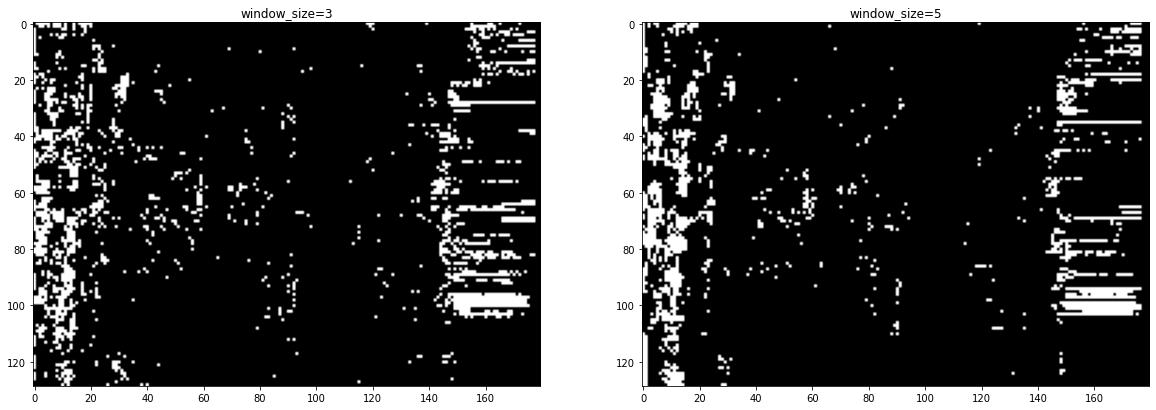

In [367]:
# Plot outliers maps side by side.

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.title('window_size=3')
plt.imshow(outliers_map_3, cmap='Greys')

plt.subplot(1,2,2)
plt.title('window_size=5')
plt.imshow(outliers_map_5, cmap='Greys')

### Task 5: Compute depth from disparity

The function below creates a matrix of depth values from a disparity matrix.

In [16]:
# Load stereo params from matlab data

import scipy.io
parameters = scipy.io.loadmat('./stereoParams_py.mat')

In [30]:
# Also takes a max_distance parameter to avoid outliers
def reconstructSceneCU(disparity, stereo_params, max_distance=10000):
    from math import sqrt
    focal_length = stereo_params['CameraParameters1_FocalLength'][0][0] # get x-translation
    baseline = sqrt(np.sum(stereo_params['TranslationOfCamera2']**2))
    depths = focal_length*baseline / disparity
    res = depths
    res[depths>max_distance] = max_distance
    return res
scene = reconstructSceneCU(left_disparity_5, parameters)

NameError: name 'left_disparity_5' is not defined

In [ ]:
# Plot resulting depths in 3D.

y = range(scene.shape[0])
x = range(scene.shape[1])

hf = plt.figure(figsize=(10,10))
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)
ha.plot_surface(X, Y, scene)

plt.show()

### Task 6: Synthetic stereo sequences

The code below demonstrates the functions above on the `teddy` data.

In [394]:
# Load images.

teddyLeft = cv2.imread('images/im2.png')
teddyLeft = cv2.cvtColor(teddyLeft, cv2.COLOR_BGR2GRAY)

teddyRight = cv2.imread('images/im6.png')
teddyRight = cv2.cvtColor(teddyRight, cv2.COLOR_BGR2GRAY)

In [395]:
teddy_disparity_1 = disparity(teddyLeft, teddyRight, window_size=3)

In [396]:
teddy_disparity_2 = disparity_2(teddyLeft, teddyRight, window_size=3)

In [403]:
teddy_disparity_3 = disparity_3(teddyLeft, teddyRight, window_size=3, threshold=0.01)

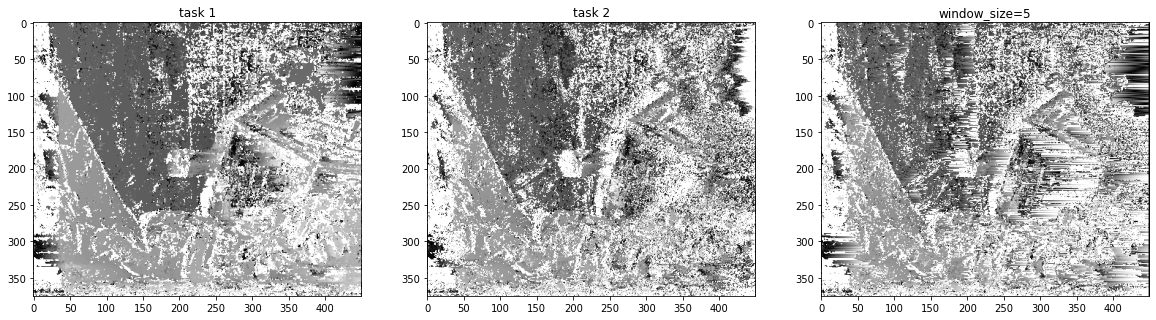

In [404]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.title("task 1")
plt.imshow(teddy_disparity_1, cmap='Greys')

plt.subplot(1,3,2)
plt.title("task 2")
plt.imshow(teddy_disparity_2, cmap='Greys')

plt.subplot(1,3,3)
plt.title("window_size=5")
plt.imshow(teddy_disparity_3, cmap='Greys')

The code below computes a map of errors (simply by difference in result) and displays it. Brighter areas indicate more errors than darker areas.

In [405]:
# Load images

expectedDisparityLeft = cv2.imread('images/disp2.png')
expectedDisparityLeft = cv2.cvtColor(expectedDisparityLeft, cv2.COLOR_BGR2GRAY)

expectedDisparityRight = cv2.imread('images/disp6.png')
expectedDisparityRight = cv2.cvtColor(expectedDisparityRight, cv2.COLOR_BGR2GRAY)

In [451]:
# Compute right disparity image as well so we can evaluate both situations.

teddy_disparity_right_3 = disparity_3(teddyRight, teddyLeft, window_size=3, threshold=0.01)
teddy_disparity_left_3 = teddy_disparity_3

In [452]:
errors_left = abs(expectedDisparityLeft-teddy_disparity_left_3)
errors_right = abs(expectedDisparityRight-teddy_disparity_right_3)

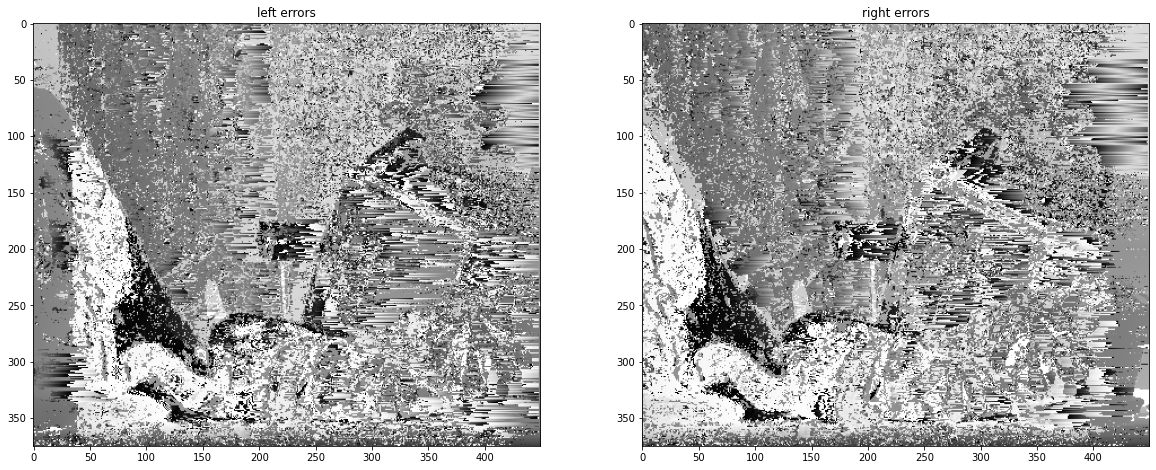

In [453]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("left errors")
plt.imshow(errors_left, cmap='Greys')

plt.subplot(1,2,2)
plt.title("right errors")
plt.imshow(errors_right, cmap='Greys')

Below you will find two histograms showing the disparity differences.

(array([[  0.,   0.,   0., ...,   7.,   0.,   0.],
        [163.,  28.,  19., ...,  19.,  15.,  11.],
        [157.,  27.,  18., ...,  10.,  24.,   9.],
        ...,
        [ 28.,   7.,  55., ...,  21.,  11.,   9.],
        [ 22.,   0., 136., ...,   7.,   1.,   0.],
        [ 23.,   0., 137., ...,   6.,   2.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 450 BarContainer objects>)

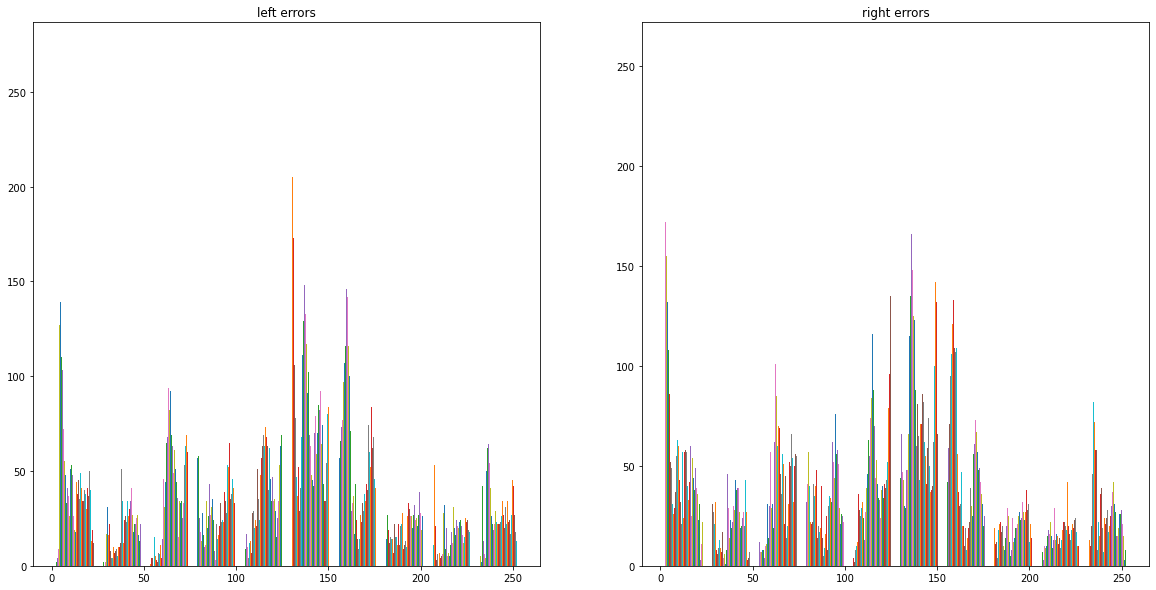

In [454]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("left errors")
plt.hist(errors_left)

plt.subplot(1,2,2)
plt.title("right errors")
plt.hist(errors_right)

### Task 7: Dynamic progrmaming

The code below implements the dynamic programming approach to generating a disparity map. All parts of the problem (A-C) are included in this single function.

In [65]:

def stereoDP(imgLeftScanLine, imgRightScanLine, maxDis=64, occ=0.01):                       # just used parameter names ScanLine, instead of epipolarLine
    backTrack = np.zeros((len(imgLeftScanLine), len(imgRightScanLine)), dtype='U2')         # String data type needs to cover at least 2 character (NW)
    costTable = np.zeros((len(imgLeftScanLine)+1, len(imgRightScanLine)+1))                 # cost table has one more row/colume. Be careful when manipulating both tables about index.

    # costTable initialization
    costTable[:, 0] = np.arange(len(imgRightScanLine)+1)*occ
    costTable[0, :] = np.arange(len(imgLeftScanLine)+1)*occ    
                                                                                
    for row in range(1, len(imgRightScanLine)+1):
        for col in range(1, len(imgLeftScanLine)+1):
            SSD = np.square(imgLeftScanLine[col-1] - imgRightScanLine[row-1])
            variableNW = costTable[row-1, col-1] + SSD
            variableW =  costTable[row, col-1] + occ
            variableN = costTable[row-1, col] + occ
            if row == 1 and col == 1:
                # Since index of this starts from 1, not zero. value needs to be adjusted
                # And, because parameters of function is functon is each row array, no need to add row info for costTable.
                costTable[row, col] = SSD
            else:
                costTable[row, col] = min(variableNW, variableW, variableN)
            
            # backTrack update
            if costTable[row, col] == variableNW:
                backTrack[row-1, col-1] = 'NW'
            elif costTable[row, col] == variableW:
                backTrack[row-1, col-1] = 'W'
            else:
                backTrack[row-1, col-1] = 'N'
    return costTable, backTrack

** Task 7: Part B: BackTracking **

In [66]:
'''
By BackTracking, update disparityMapLeftRowDP, disparityMapRightRowDP
Needless to say, this function is for each row of images, not wholly 2D image.
'''
def backTracking(imgLeft, disparityRow, costTable, backTrack, maxDisp):
    disparityMapRow = np.zeros(imgLeft.shape[1], dtype=imgLeft.dtype)
    disparityMapRow[:] = np.nan
    row = backTrack.shape[0] - 1
    col = backTrack.shape[1] - 1
    # print("size: row, col is {}, {}".format(row, col))
    # print(row)
    while row > 0 and col > 0:
        if backTrack[row, col] == 'NW':
            # print("NW!!!!!")
            # Handle with costTable by adjusting suitable index (add +1 )
            disparityMapRow[col] = min(np.abs(col-row), maxDisp)
            # disparityMapLeftDP[disparityRow, col] = costTable[row+1, col+1]
            # disparityMapRightDP[disparityRow, row] = costTable[row+1, col+1]
            # print("row col is {}, {}, {}".format(row, col, "NW"))
            row -= 1
            col -= 1
        elif backTrack[row, col] == 'N':
            # occlusion case. No need to assign value zero because already disparityMapLeft/RightDP was created by np.zero
            # Update: need to change value to np.nan related to Task 7: Part C
            # However, to be clear in the future use, insert redundant code
            disparityMapRow[col] = np.nan
            # disparityMapLeftDP[disparityRow, col] = min(np.abs(col-row)+1, maxDisp)
            # print("row col is {}, {}, {}".format(row, col, "N"))
            row -= 1
        else:
            # Same as 'N' case in terms of treating value zero at this case
            # Update: same reason
            # it is disocculusion case.
            disparityMapRow[col] = np.nan
            # print("row col is {}, {}, {}".format(row, col, "W"))
            col -= 1
    return disparityMapRow

def disparityDP(imgLeft, imgRight, occ=0.01, maxDisp=64):
    disparityMapDP = np.zeros(imgLeft.shape, dtype=imgLeft.dtype)
    for i in range(imgLeft.shape[0]):
        costTable, backTrack = stereoDP(imgLeft[i], imgRight[i], maxDisp, occ)
        # print(costTable.shape, backTrack.shape)
        disparityMapDP[i,:] = backTracking(imgLeft, i, costTable, backTrack, maxDisp)
    return disparityMapDP

In [67]:
frameLeftGray = frameLeftGray.astype('float32')
frameRightGray = frameRightGray.astype('float32')
disparityDP_01_32 = disparityDP(frameLeftGray, frameRightGray, occ=0.01, maxDisp=32)

** Task 7: part C: Displaying the disparity map **

In [68]:
# Since non disparity index were filled with np.nan, it should be treated to map enough to apply imshow.

def colorizeDP(disparityDP):
    #  1. Map disparity into the range [0, 1]
    # Caution: Don't use np.min because nan vaule will be max and min. Need to exclude nan value
    maxD, minD = np.nanmax(disparityDP), np.nanmin(disparityDP)
    scaleD = 1 / (maxD - minD)
    scaledDisparity = scaleD * disparityDP

    # 2. Colorized occuluded pixels to be red
    # Declare dColor having 3 channel (RGB). Everything else is same property as scaledDisparity
    # Then, assign each channel layer (R, G, B) as same value as scaledDisparity
    # When applyting values of scaledDisparity to channel layer, index having value np.nan will be changed to Red color.

    dColor = np.zeros((scaledDisparity.shape[0], scaledDisparity.shape[1], 3), dtype=scaledDisparity.dtype)
    dColor[:,:,0] = np.where(np.isnan(scaledDisparity), 1, scaledDisparity)
    dColor[:,:,1] = np.where(np.isnan(scaledDisparity), 0, scaledDisparity)
    dColor[:,:,2] = np.where(np.isnan(scaledDisparity), 0, scaledDisparity)
    return dColor

In [70]:
disparityDP_01_32 = colorizeDP(disparityDP_01_32)

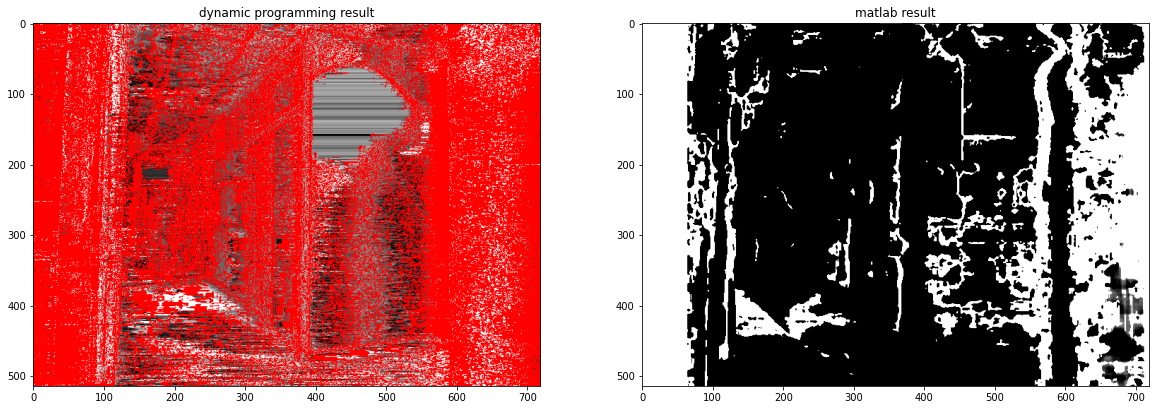

In [71]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("dynamic programming result")
plt.imshow(disparityDP_01_32)

plt.subplot(1,2,2)
plt.title("matlab result")
plt.imshow(matlabResult, cmap='Greys')